In [8]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from sklearn.utils import shuffle
import pandas as pd
from keras.preprocessing.image import *
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2018)

def show_loss(Model):
    
    fig, ax = plt.subplots(2,1,figsize=(16, 8))
    his_model = Model.history
    history = his_model.history

    ax[0].plot(history['loss'], color='b', label="loss")
    ax[0].plot(history['val_loss'], color='r', label="val_loss",axes =ax[0])
    ax[0].set_ylim(0, 0.05)
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].grid(True)

    
    ax[1].plot(history['acc'], color='g', label="acc")
    ax[1].plot(history['val_acc'], color='c',label="val_acc")
    ax[1].set_ylim(0.98, 1)
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].grid(True)
    
def get_base_model_feature():
    
    base_model = ResNet50(input_tensor=Lambda(resnet50.preprocess_input)(Input((224,224,3))), 
                               weights='imagenet',include_top = False)

    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    gen1 = ImageDataGenerator()  #图片生成器ImageDataGenerator
    train_generator = gen1.flow_from_directory("train2",(224,224),shuffle=False,batch_size=16)
    test_generator = gen1.flow_from_directory("test2", (224,224), shuffle=False, batch_size=16,class_mode=None)

    train = model.predict_generator(train_generator,steps = train_generator.samples/16)
    test = model.predict_generator(test_generator,steps = test_generator.samples/16)
    
    return train,test,train_generator.classes

X_train,X_test,y_train = get_base_model_feature()

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 110us/step - loss: 0.1166 - acc: 0.9556 - val_loss: 0.0430 - val_acc: 0.9860
Epoch 2/10
20000/20000 [==============================] - 1s 26us/step - loss: 0.0466 - acc: 0.9831 - val_loss: 0.0491 - val_acc: 0.9834
Epoch 3/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0405 - acc: 0.9856 - val_loss: 0.0367 - val_acc: 0.9870
Epoch 4/10
20000/20000 [==============================] - 1s 30us/step - loss: 0.0380 - acc: 0.9867 - val_loss: 0.0461 - val_acc: 0.9844
Epoch 5/10
20000/20000 [==============================] - 1s 26us/step - loss: 0.0372 - acc: 0.9868 - val_loss: 0.0386 - val_acc: 0.9874
Epoch 6/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0357 - acc: 0.9869 - val_loss: 0.0353 - val_acc: 0.9862
Epoch 7/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0341 - acc: 0.9876 - val_loss: 0.0360 - val_acc

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


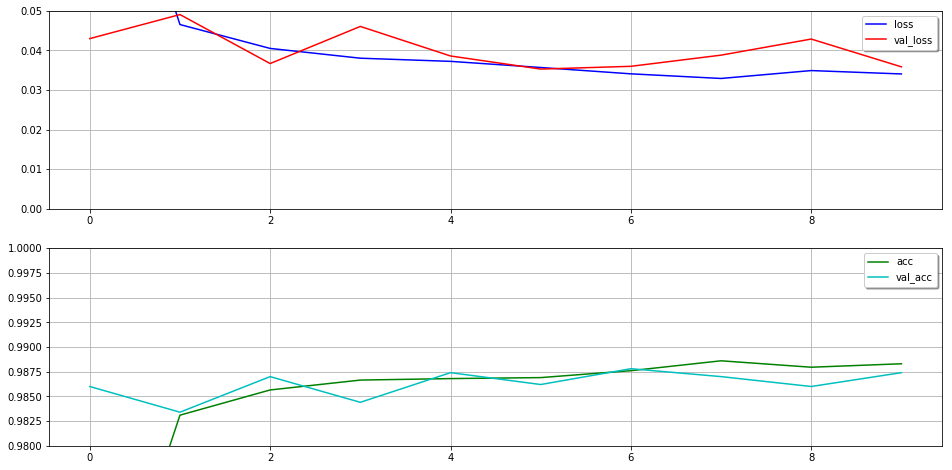

In [9]:

def fine_tuning_net():
    
    X_train1, y_train1 = shuffle(X_train, y_train)
    input_tensor = Input(X_train1.shape[1:])
    x = Dropout(0.5)(input_tensor)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input_tensor, x)
    
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model.fit(X_train1, y_train1, batch_size=128, epochs=10, validation_split=0.2)
    show_loss(model)
    y_pred = model.predict(X_test, verbose=1)
    y_pred = y_pred.clip(min=0.005, max=0.995)
    return y_pred

y_pred1 = fine_tuning_net()


def result_2csv():
    df = pd.read_csv("sample_submission.csv")
    gen2 = ImageDataGenerator()
    test_generator = gen2.flow_from_directory("test2", (299, 299), shuffle=False,
                                         batch_size=16, class_mode=None)

    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        df.set_value(index-1, 'label', y_pred1[i])

    df.to_csv('pred.csv', index=None)

result_2csv()